# Minst 手写数字识别

## 多层神经网络建模与重构全连接层

In [1]:
import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_core.examples.tutorials.mnist.input_data as input_data

In [2]:
# 获取 Mints手写数字数据集
mnist = input_data.read_data_sets("Data/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting Data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting Data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting Data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting Data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 构建全连接层

In [3]:
def fcn_layer(
        inputs,  # 输入数据
        input_dim,  # 输入神经元数量
        output_dim,  # 输出神经元数量
        activation=None,  # 激活函数
):
    # 以截断正态分布随机数初始化W
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1))

    # 以0初始化b
    b = tf.Variable(tf.zeros([output_dim]))

    # 建立表达式：inputs * W + b
    XWb = tf.matmul(inputs, W) + b

    # 默认不使用激活函数
    if activation is None:
        outputs = XWb
    else:
        # 若传入激活函数，则用其对输出结果进行变换
        outputs = activation(XWb)

    return outputs

## 构建输入层（单隐层、多隐层）

In [4]:
# 定义标签数据占位符
x = tf.placeholder(tf.float32, [None, 784], name="X")
y = tf.placeholder(tf.float32, [None, 10], name="Y")

# TensorBoard：图像数据准备
# 参数代表：
# -1：此处代表未定行数
# 28 与 28，表示28 * 28的图像数据
# 1：表示颜色通道数，1表示单通道无色
image_shaped_input = tf.reshape(x, [-1, 28, 28, 1])

# TensorBoard：输出10张图
tf.summary.image("input", image_shaped_input, 10)

<tf.Tensor 'input:0' shape=() dtype=string>

In [5]:
H1_NN = 256
H2_NN = 64
H3_NN = 32

## 构建隐藏层（单隐层、多隐层）

In [6]:
# 隐层包含256个神经元
h1 = fcn_layer(inputs=x,
               input_dim=784,
               output_dim=H1_NN,
               activation=tf.nn.relu)

h2 = fcn_layer(inputs=h1,
               input_dim=H1_NN,
               output_dim=H2_NN,
               activation=tf.nn.relu)

h3 = fcn_layer(inputs=h2,
               input_dim=H2_NN,
               output_dim=H3_NN,
               activation=tf.nn.relu)

## 构建输出层（单隐层、多隐层）

In [7]:
forward = fcn_layer(inputs=h3,
                    input_dim=H3_NN,
                    output_dim=10,
                    activation=None)

In [8]:
pred = tf.nn.softmax(forward)

In [9]:
# TensorBoard前向输出值以直方图显示
tf.summary.histogram("forward", forward)

<tf.Tensor 'forward:0' shape=() dtype=string>

## 定义损失函数

In [10]:
# 交叉熵
# 采用TF封装好的结合了Softmax的交叉熵函数
# 此处无需人工进行分类，直接传入前向计算结果即可，函数将自动进行Softmax分类
# 此函数将会避免由于人工计算中出现log(0)值导致最终结果为NaN的数据不稳问题
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=forward, labels=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
# TensorBoard：将loss损失以标量显示
tf.summary.scalar("loss", loss_function)

<tf.Tensor 'loss:0' shape=() dtype=string>

## 设置训练参数

In [12]:
train_epochs = 40
batch_size = 50
total_batch = int(mnist.train.num_examples / batch_size)
display_step = 1
learning_rate = 0.01

## 选择优化器

In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

## 定义准确率

In [14]:
# 对比预测值与正确值
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(pred, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
# TensorBoard：将准确率以标量显示
tf.summary.scalar("Accuracy", accuracy)

<tf.Tensor 'Accuracy:0' shape=() dtype=string>

## 保存训练模型

+ 防止训练过程被`意外中断`
+ 保存训练结束的模型

In [16]:
# 存储模型的粒度（此处为每执行完10次保存1次）
# TF中每次保存将会保存5个模型，超过5个模型的将会保存最新模型，并删去旧模型
save_step = 10

ckpt_dir = "Model_ckpt/"

if not os.path.exists(ckpt_dir):
    os.mkdirs(ckpt_dir)

# 训练并保存模型
saver = tf.train.Saver()

## 模型训练

In [17]:
# 准备好会话与变量
startTime = time()

session = tf.Session()
session.run(tf.global_variables_initializer())

In [18]:
# TensorBoard：合并所有summary
merged_summary_op = tf.summary.merge_all()

# 创建写入符
writer = tf.summary.FileWriter("Log/7-Mnist-NN-Pro-Rebuild-FC", session.graph)

In [19]:
for epoch in range(train_epochs):
    for batch in range(total_batch):
        # 读取批次数据
        xs, ys = mnist.train.next_batch(batch_size)

        # 执行批次训练
        session.run(optimizer, feed_dict={x: xs, y: ys})

        # 生成每次要写入的Summary信息
        summary_str = session.run(merged_summary_op, feed_dict={x: xs, y: ys})
        # 加入Summary
        writer.add_summary(summary_str, epoch)

    # total_batch个批次使用验证数据计算误差与准确率
    loss, acc = session.run([loss_function, accuracy],
                            feed_dict={x: mnist.validation.images, y: mnist.validation.labels})

    if (epoch + 1) % display_step == 0:
        print("Train epoch: ", "%02d" % (epoch + 1),
              "Loss = ", "{:.9f}".format(loss),
              "Accuracy = ", "{:.4f}".format(acc))

    # 在训练过程中按训练次数保存临时模型副本
    if (epoch + 1) % save_step == 0:
        saver.save(session, os.path.join(ckpt_dir,
                                         "mnist_h256_model_{:06d}.ckpt".format(epoch + 1)))

# 保存训练完成模型
saver.save(session, os.path.join(ckpt_dir, "mnist_h256_model.ckpt"))
print("Model Saved! ")

duration = time() - startTime
print("Total Finished Time: ", "{:.2f}".format(duration))

Train epoch:  01 Loss =  0.160299152 Accuracy =  0.9542
Train epoch:  02 Loss =  0.161491096 Accuracy =  0.9596
Train epoch:  03 Loss =  0.129182220 Accuracy =  0.9658
Train epoch:  04 Loss =  0.143679783 Accuracy =  0.9674
Train epoch:  05 Loss =  0.153141305 Accuracy =  0.9610
Train epoch:  06 Loss =  0.183307886 Accuracy =  0.9632
Train epoch:  07 Loss =  0.142774165 Accuracy =  0.9678
Train epoch:  08 Loss =  0.158177570 Accuracy =  0.9664
Train epoch:  09 Loss =  0.181910351 Accuracy =  0.9664
Train epoch:  10 Loss =  0.131723762 Accuracy =  0.9722
Train epoch:  11 Loss =  0.166536763 Accuracy =  0.9684
Train epoch:  12 Loss =  0.169295534 Accuracy =  0.9708
Train epoch:  13 Loss =  0.169015929 Accuracy =  0.9720
Train epoch:  14 Loss =  0.181511074 Accuracy =  0.9716
Train epoch:  15 Loss =  0.149564356 Accuracy =  0.9738
Train epoch:  16 Loss =  0.151932061 Accuracy =  0.9734
Train epoch:  17 Loss =  0.242564768 Accuracy =  0.9712
Train epoch:  18 Loss =  0.160858050 Accuracy = 

## 读取此前保存的模型

In [20]:
ckpt = tf.train.get_checkpoint_state(ckpt_dir)

if ckpt and ckpt.model_checkpoint_path:
    # 从已保存的模型中读取参数，还原到当前会话中
    saver.restore(session, ckpt.model_checkpoint_path)

    print("Restore model from: " + ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from Model_ckpt/mnist_h256_model.ckpt
Restore model from: Model_ckpt/mnist_h256_model.ckpt


## 评估模型（正常训练后所得）

In [21]:
acc_test = session.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})

print("Train accuracy: ", acc_test)

Train accuracy:  0.9731


## 输出还原模型的准确率（从文件中恢复所得）

In [22]:
# 不难看出，恢复结果与正常训练结果相当
print("Accuracy: ", accuracy.eval(session=session,
                                  feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Accuracy:  0.9731


## 模型运用

In [23]:
# 由于pred预测解雇是one-hot编码，需要将其转换为0~9的数组
prediction_result = session.run(tf.argmax(pred, 1), feed_dict={x: mnist.test.images})

In [24]:
# 查看预测结果中的前10项
prediction_result[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [25]:
## 找出预测错误
compare_lists = prediction_result == np.argmax(mnist.test.labels, 1)

print(compare_lists)

[ True  True  True ...  True  True  True]


In [26]:
err_list = [i for i in range(len(compare_lists)) if compare_lists[i] == False]
print("Err list length: ", len(err_list), "\n")
print(err_list)

Err list length:  269 

[93, 115, 247, 259, 266, 321, 340, 359, 381, 391, 403, 445, 447, 450, 495, 551, 582, 610, 674, 684, 720, 726, 761, 839, 844, 846, 883, 924, 938, 947, 1014, 1039, 1107, 1112, 1181, 1182, 1226, 1242, 1247, 1260, 1319, 1328, 1356, 1393, 1425, 1433, 1444, 1494, 1522, 1530, 1549, 1600, 1678, 1681, 1717, 1751, 1754, 1782, 1800, 1813, 1828, 1850, 1901, 1955, 1969, 2016, 2050, 2053, 2070, 2073, 2093, 2098, 2109, 2118, 2130, 2135, 2182, 2189, 2237, 2272, 2293, 2298, 2329, 2369, 2387, 2406, 2426, 2433, 2447, 2454, 2488, 2534, 2550, 2597, 2598, 2648, 2654, 2770, 2810, 2877, 2896, 2921, 2927, 2939, 2945, 2953, 3030, 3091, 3108, 3240, 3246, 3284, 3289, 3384, 3422, 3451, 3475, 3503, 3520, 3542, 3549, 3558, 3567, 3597, 3662, 3751, 3767, 3776, 3780, 3808, 3811, 3853, 3906, 3941, 3943, 3951, 3976, 3987, 4000, 4065, 4075, 4145, 4163, 4176, 4199, 4205, 4224, 4265, 4289, 4306, 4374, 4399, 4433, 4497, 4536, 4547, 4548, 4571, 4575, 4601, 4635, 4699, 4724, 4731, 4740, 4807, 4808, 4814

In [27]:
## 定义一个输出错误分类函数
def print_predict_errs(labels, prediction):
    count = 0

    compare_lists = (prediction == np.argmax(labels, 1))
    err_list = [i for i in range(len(compare_lists)) if compare_lists[i] == False]

    for x in err_list:
        print("index: " + str(x) + " 标签值 = ", np.argmax(labels[x]), "预测值 = ", prediction[x])

        count = count + 1

    print("总计: ", count)

In [28]:
print_predict_errs(labels=mnist.test.images, prediction=prediction_result)

index: 0 标签值 =  355 预测值 =  7
index: 1 标签值 =  97 预测值 =  2
index: 2 标签值 =  406 预测值 =  1
index: 3 标签值 =  262 预测值 =  0
index: 4 标签值 =  299 预测值 =  4
index: 5 标签值 =  157 预测值 =  1
index: 6 标签值 =  287 预测值 =  4
index: 7 标签值 =  324 预测值 =  9
index: 8 标签值 =  425 预测值 =  5
index: 9 标签值 =  357 预测值 =  9
index: 10 标签值 =  216 预测值 =  0
index: 11 标签值 =  325 预测值 =  6
index: 12 标签值 =  211 预测值 =  9
index: 13 标签值 =  155 预测值 =  0
index: 14 标签值 =  126 预测值 =  1
index: 15 标签值 =  624 预测值 =  5
index: 16 标签值 =  182 预测值 =  9
index: 17 标签值 =  685 预测值 =  7
index: 18 标签值 =  257 预测值 =  3
index: 19 标签值 =  632 预测值 =  4
index: 20 标签值 =  601 预测值 =  9
index: 21 标签值 =  374 预测值 =  6
index: 22 标签值 =  94 预测值 =  6
index: 23 标签值 =  161 预测值 =  5
index: 24 标签值 =  399 预测值 =  4
index: 25 标签值 =  481 预测值 =  0
index: 26 标签值 =  298 预测值 =  7
index: 27 标签值 =  604 预测值 =  4
index: 28 标签值 =  150 预测值 =  0
index: 29 标签值 =  406 预测值 =  1
index: 30 标签值 =  232 预测值 =  3
index: 31 标签值 =  603 预测值 =  1
index: 32 标签值 =  149 预测值 =  3
index: 33 标签值 =  490 预

## 模型可视化

In [29]:
# 定义可视化函数
def plot_images_labels_prediction(
        images,  # 图像列表
        labels,  # 标签列表
        prediction,  # 预测值列表（若传入空表则为展示数据集中image与对应标签）
        index,  # 从第index个开始显示
        num=10,  # 缺省一次显示10幅
):
    # 获取当前图表
    flg = plt.gcf()

    # 1英寸等于2.54cm
    flg.set_size_inches(10, 12)

    # 最多展示25个要处理的子图
    if num > 25:
        num = 25

    for i in range(0, num):
        # 获取当前要处理的子图
        ax = plt.subplot(5, 5, i + 1)

        # 显示第index个图像
        ax.imshow(np.reshape(images[index], (28, 28), ), cmap="binary")

        # 构建该图上要显示的title信息
        title = "Label = " + str(np.argmax(labels[index]))

        if len(prediction) > 0:
            title += ", Pred = " + str(prediction[index])

        ax.set_title(title, fontsize=10)

        index += 1

    plt.show()

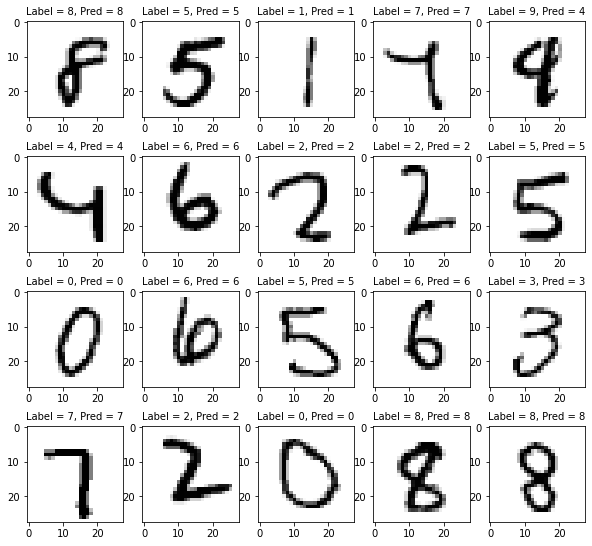

In [30]:
plot_images_labels_prediction(
    mnist.test.images,
    mnist.test.labels,
    prediction_result,
    355,
    20
)